<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/ctc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [3]:
os.chdir("/content")
if not os.path.exists("/content/AI4Good---Meza-OCR-Challenge"):
  !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
if not os.path.exists("/content/2019-hackathon-ocr-wymbah"):
  !git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
os.chdir("/content/2019-hackathon-ocr-wymbah")
!git pull

from importlib import reload
import util.file
reload(util.file)

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/colaprograms/2019-hackathon-ocr-wymbah
   d925a11..dd92b2a  master     -> origin/master
Updating d925a11..dd92b2a
Fast-forward
 notebooks/ctc_test.ipynb | 282 ++++++++++++++++++++++++++++++++++++++++++-----
 1 file changed, 252 insertions(+), 30 deletions(-)
Using path /content/AI4Good---Meza-OCR-Challenge
Using path /content/AI4Good---Meza-OCR-Challenge


<module 'util.file' from '/content/2019-hackathon-ocr-wymbah/util/file.py'>

1,55


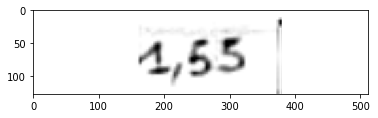

torch.Size([20, 3, 128, 512])

In [4]:
from util.file import FileHolder
fh = FileHolder()
inp, outp = fh.get_batch(1)

for file, val in zip(inp, outp):
  print(val)
  p.imshow(file)
  p.show()

def to_tensor(buf):
  buf = 2*buf - 1
  return torch.Tensor(buf).permute(0, 3, 1, 2)

def get_batch(batchsize, validation=False):
  inp, outp = fh.get_batch(batchsize, validation)
  inp = np.stack(inp)
  inp = to_tensor(inp)
  return inp, outp

get_batch(20)[0].shape

In [5]:
import torch.nn as nn
import torch.optim as optim
import torchvision

resnet = torchvision.models.resnet.resnet34(True)

"Cut off the last two layers"
def forward(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  x = self.maxpool(x)

  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)

  return x

import types
resnet.forward = types.MethodType(forward, resnet)
resnet = resnet.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [14]:
chars = "0123456789-,."
nchars = len(chars)
idx = {}
for i, c in enumerate(chars): idx[c] = i

ntraining = len(fh.info['training'])

BATCH_SIZE = 64

def run():
  lstm = nn.LSTM(512, 128, bidirectional=True).cuda()
  dense = nn.Linear(1024, nchars).cuda()
  avgpool = nn.AdaptiveAvgPool2d((1, 16)).cuda()

  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=9)

  for epoch in range(20):
    running_loss = 0.0
    for i in range(int(ntraining / BATCH_SIZE)):
      inp, outp = get_batch(BATCH_SIZE)
      inp = resnet(inp.cuda())
      inp = avgpool(inp)
      inp = inp.reshape([-1, 512, 16]).permute(0, 2, 1)
      print(inp.shape)
      optimizer.zero_grad()
      inp, _ = lstm(inp)
      inp = dense(inp)
      loss = ctc(probs, target, input_lengths, target_lengths, reduction='None')
      loss.backward()
      optimizer.step()

run()

RuntimeError: ignored

In [226]:
image_tensor = torch.Tensor(image)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
out = resnet(image_tensor)
print(out)
print(out.shape)

tensor([[[[0.0000e+00, 8.4632e-03, 4.4118e-01,  ..., 3.5947e-01,
           0.0000e+00, 0.0000e+00],
          [1.5710e+00, 1.6492e+00, 4.3799e-01,  ..., 1.9591e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5652e+00,
           1.0369e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 2.7234e-01,  ..., 4.7540e+00,
           1.5719e+00, 0.0000e+00]],

         [[8.1148e-01, 6.8881e-01, 1.4770e+00,  ..., 2.5300e+00,
           2.8111e-01, 0.0000e+00],
          [0.0000e+00, 1.1480e-01, 1.6761e+00,  ..., 3.0082e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 3.6867e-01,  ..., 6.7188e-02,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 7.3576e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6493e-01,
           6.6963e-01,